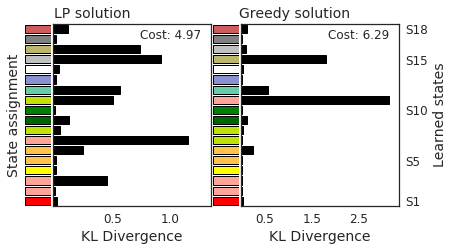

In [5]:
%matplotlib inline

import os as os
import collections as col
import itertools as itt
import pickle as pck
import time as ti
import json as js

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
from pandas.errors import EmptyDataError
import seaborn as sns
import pulp as plp

# What does this do?
# State assignment for newly trained
# ChromHMM 18-state model relative to
# REMC 18-state model based on KL divergence

date = '20180716'

run_plot_state_assign = True
save_figures = True
save_diss = True

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['emission', 'replicate']
segmentations = ['cmm18', 'ecs18', 'ecs10']
cmm_state_colors = '/home/pebert/work/code/mpggit/statediff/annotation/chromhmm_18/colormap_18_core_K27ac.tab'
cmm_model_emissions = '/home/pebert/work/code/mpggit/statediff/annotation/chromhmm_18/emissions_18_core_K27ac.txt'

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'

new_model_emissions = os.path.join(fhgfs_base, 'chromhmm/deep/test_new18', 'emissions_18_new18_.txt')

sciddo_deep_dir = os.path.join(fhgfs_base, 'sciddo', 'deep')
overlap_dir = os.path.join(fhgfs_base, 'bedtools', 'deep', 'inv_isect')
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

data_root = os.path.join(fhgfs_base, 'sciddo', 'deep')
isect_root = os.path.join(fhgfs_base, 'bedtools', 'deep')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'
fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
fig_diss = '/home/pebert/work/code/mpggit/dissertation/Figures/diffchrom'


def load_emission_matrices():
    """
    """
    new18 = pd.read_csv(new_model_emissions,
                        sep='\t', header=0, index_col=0)
    new18.index.name = 'state'
    new18.index = ['E' + str(i) for i in new18.index]

    cmm18 = pd.read_csv(cmm_model_emissions,
                        sep='\t', header=0, index_col=0)
    cmm18.index.name = 'state'

    new18 = new18[cmm18.columns]
    # assert that histone marks match
    assert all(new18.columns == cmm18.columns), 'Column mismatch'
    return cmm18, new18


def compute_kldiv_and_greedy(learned_model, fix_model):
    """
    """
    pairwise_kldiv = []
    state_pairs = []
    for learn_row in learned_model.itertuples(index=True, name=None):
        current_row = []
        for fix_row in fix_model.itertuples(index=True, name=None):
            kl = stats.entropy(learn_row[1:], fix_row[1:])
            current_row.append(kl)
            state_pairs.append((kl, learn_row[0], fix_row[0]))
        pairwise_kldiv.append(current_row)

    df = pd.DataFrame(pairwise_kldiv,
                      index=learned_model.index,
                      columns=fix_model.index,
                      dtype=np.float32)

    taken1 = []
    taken2 = []
    assign = []
    cost_greedy = 0
    # compute greedy assignment = always select
    # state pair with lowest KL divergence
    for kl, s1, s2 in sorted(state_pairs):
        if s1 not in taken1 and s2 not in taken2:
            assign.append((s1, s2, kl))
            cost_greedy += kl
            taken1.append(s1)
            taken2.append(s2)
    assert len(set(taken1)) == len(taken1) == 18, 'Miscalculated greedy assignment'
    assert len(set(taken2)) == len(taken2) == 18, 'Miscalculated greedy assignemnt'
    assign = sorted(assign, key=lambda x: int(x[0].strip('E')))
    return df, assign, cost_greedy


def compute_lp_solution(learned_model, fix_model, kldiv):
    """
    """
    state_pairs = list(itt.product(learned_model.index, fix_model.index))

    select_pair = plp.LpVariable.dicts('select', state_pairs,
                                       lowBound = 0, upBound = 1,
                                       cat=plp.LpInteger)

    state_pairing_model = plp.LpProblem('State pairing model', plp.LpMinimize)
    
    # Objective function
    state_pairing_model += sum([kldiv.at[p[0],p[-1]] * select_pair[p] for p in state_pairs])
    
    # Constraint: select 18 pairs
    state_pairing_model += sum([select_pair[p] for p in state_pairs]) == 18, 'Number_of_pairs'
    
    # Constraint: each state must be selected once (learned model)
    for learned_state in learned_model.index.tolist():
        state_pairing_model += sum([select_pair[p] for p in state_pairs if learned_state in p]) == 1, \
                                    'Select_LEARNED_state_{}'.format(learned_state)
    
    # Constraint: each state must be selected once (fix model)
    for fix_state in fix_model.index.tolist():
        state_pairing_model += sum([select_pair[p] for p in state_pairs if fix_state in p]) == 1, \
                                    'Select_FIX_state_{}'.format(fix_state)
    state_pairing_model.solve()

    assign = []
    cost = 0
    for pair in state_pairs:
        if select_pair[pair].value() == 1.:
            c = kldiv.at[pair[0], pair[-1]]
            assign.append((pair[0], pair[-1], c))
            cost += c
    assign = sorted(assign, key=lambda x: int(x[0].strip('E')))
    return assign, cost


def to_rgb(color):
    
    r, g, b = color.split(',')
    r = int(r) / 255
    g = int(g) / 255
    b = int(b) / 255
    return r,g,b

def plot_both_assignments(lp_solution, lp_cost,
                          greedy_solution, greedy_cost, fkey):
    """
    """
    
    fig, (ax_c1, ax_lp, ax_c2, ax_gr) = plt.subplots(figsize=fig_sizes['two_col']['half'],
                                                     nrows=1, ncols=4, sharex=False, sharey=False,
                                                     gridspec_kw={'width_ratios': [1, 6, 1, 6]})
    
    plt.subplots_adjust(wspace=0.02)
        
    colors = pd.read_csv(cmm_state_colors, sep='\t', header=None,
                         names=['rgb'], index_col=0)
    # replace color of TSS flanking regions for better readability
    colors.loc[[2,3,4], 'rgb'] = '255,164,152'
    
    y_pos = list(range(1, colors.shape[0] + 1))
        
    lp_ordering = [int(x[1].split('_')[0]) for x in lp_solution]
    lp_pair_costs = [t[2] for t in lp_solution]
    lp_colors = colors.loc[lp_ordering, 'rgb']
    lp_colors = [to_rgb(c) for c in lp_colors]

    ax_c1.barh(y_pos, np.ones(len(y_pos), dtype=np.int8),
               color=lp_colors, edgecolor='black', linewidth=1)
    ax_c1.set_xlim(0, 1)
    ax_c1.set_ylim(0.5, 18.5)
    ax_c1.set_xticks([])
    ax_c1.spines['top'].set_visible(False)
    ax_c1.spines['bottom'].set_visible(False)
    ax_c1.spines['left'].set_visible(False)
    ax_c1.spines['right'].set_visible(False)
    ax_c1.set_ylabel('State assignment', fontsize=14)
    ax_c1.set_yticks([])
    
    ax_lp.barh(y_pos, lp_pair_costs,
               color='black', edgecolor='black', linewidth=1)
    ax_lp.set_xlim(-0.01, max(lp_pair_costs) + 0.2)
    ax_lp.set_ylim(0.5, 18.5)
    ax_lp_xticks = [0.5, 1.]
    ax_lp.set_xticks(ax_lp_xticks)
    ax_lp.set_xticklabels(list(map(str, ax_lp_xticks)), fontsize=12)
    ax_lp.set_yticks([])
    ax_lp.set_xlabel('KL Divergence', fontsize=14)
    ax_lp.text(x=0.55, y=0.92, s='Cost: {}'.format(np.round(lp_cost, 2)),
               fontsize=12, transform=ax_lp.transAxes)
    tt = ax_lp.set_title('LP solution', fontsize=14)
    tt.set_position((0.25, 1.))
    
    greedy_ordering = [int(x[1].split('_')[0]) for x in greedy_solution]
    greedy_pair_costs = [t[2] for t in greedy_solution]
    greedy_colors = colors.loc[greedy_ordering, 'rgb']
    greedy_colors = [to_rgb(c) for c in greedy_colors]
    
        
    ax_gr.barh(y_pos, greedy_pair_costs,
                 color='black', edgecolor='black', linewidth=1)
    ax_gr.set_xlim(-0.01, max(greedy_pair_costs) + 0.2)
    ax_gr.set_ylim(0.5, 18.5)
    ax_gr_xticks = [0.5, 1.5, 2.5]
    ax_gr.set_xticks(ax_gr_xticks)
    ax_gr.set_xticklabels(list(map(str, ax_gr_xticks)), fontsize=12)
    ax_gr.set_xlabel('KL Divergence', fontsize=14)
    ax_gr.text(x=0.55, y=0.92, s='Cost: {}'.format(np.round(greedy_cost, 2)),
               fontsize=12, transform=ax_gr.transAxes)
    yticks = [1, 5, 10, 15, 18]
    ax_gr.set_yticks(yticks)
    ax_gr.set_yticklabels(['S{}'.format(i) for i in yticks], fontsize=12)
    ax_gr.set_ylabel('Learned states', fontsize=14)
    ax_gr.yaxis.tick_right()
    ax_gr.yaxis.set_label_position('right')
    tt = ax_gr.set_title('Greedy solution', fontsize=14)
    tt.set_position((0.34, 1.))
    
    ax_c2.barh(y_pos, np.ones(len(y_pos), dtype=np.int8),
               color=greedy_colors, edgecolor='black', linewidth=1)
    ax_c2.set_xlim(0, 1)
    ax_c2.set_ylim(0.5, 18.5)
    ax_c2.set_xticks([])
    ax_c2.set_yticks([])
    ax_c2.spines['top'].set_visible(False)
    ax_c2.spines['bottom'].set_visible(False)
    ax_c2.spines['left'].set_visible(False)
    ax_c2.spines['right'].set_visible(False)
    
    return fig, []


def plot_state_assignment():
    
    remc_model, deep_model = load_emission_matrices()
    kl_lut, greedy_assign, greedy_cost = compute_kldiv_and_greedy(deep_model, remc_model)
    lp_assign, lp_cost = compute_lp_solution(deep_model, remc_model, kl_lut)
        
    fig, exart = plot_both_assignments(lp_assign, lp_cost,
                                       greedy_assign, greedy_cost, 'SX')

    if save_figures:
        outname = 'fig_SX_learned-model_state-assign'
        outfolder = fig_collect
        if save_diss:
            outfolder = fig_diss

        out_pdf = os.path.join(outfolder, outname + '.pdf')
        fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
        
        if not save_diss:
            out_png = os.path.join(outfolder, outname + '.png')
            fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
    return 0

if run_plot_state_assign:
    plot_state_assignment()